In [1]:
# This notebook visualize the p-vals across all tumors
# This notebook start from the non-exp gene mapping in expression file
import pandas as pd
import os, pickle, shutil, time
from tqdm import tqdm
from collections import Counter

***
### Save sig_genes.txt paths

In [10]:
### For feature type, get the number of successfully run 
dir_res = '../mutsig_out/'
dir_cohort = '../anno_ref/cohorts'
dir_out = '../mutsig_out/anlyze'
def get_res_path(feature_type, run,  syn_nsyn = None):
    dir_res_feat = os.path.join(dir_res,syn_nsyn,run,feature_type)

    # Append the path of significant gene files into a list
    lsig_f = []
    for feat in os.listdir(dir_res_feat):
        fsig = [i for i in os.listdir(os.path.join(dir_res_feat,feat)) \
                if i.endswith('sig_genes.txt')]
        if len(fsig) > 0: 
            fsig_path = os.path.join(dir_res_feat, feat, fsig[0])
            lsig_f.append(fsig_path)
#     pickle.dump(lsig_f, open(os.path.join(dir_out, \
#             feature_type+'.'+syn_nsyn+'.sig_genes.pathlist.'+run+'.pkl'),'wb'))

In [17]:
# features = ['histology','organ','origin','system','pancancer']
get_res_path('histology', 'cohort_072221', 'syn')

***
### Get failed cohort

In [18]:
### path
dir_res = '../mutsig_out/'
dir_cohort = '../anno_ref/cohorts'
dir_out = '../mutsig_out/anlyze'

In [19]:
def get_failed_cohort(feature_type,run, syn_nsyn):
    # Read feat info df
    df_feat = pd.read_csv(os.path.join(dir_cohort, feature_type+'.csv'))

    # Get dictionary of feat-patient number and sort by patient number
    dict_feat_np = dict(Counter(df_feat[feature_type]))
    dict_feat_np = {k: v for k, v in sorted(dict_feat_np.items(), key=lambda item: item[1])}
#     print(dict_feat_np)

    # Read sig file path list
    pathlist = pickle.load(open(os.path.join(dir_out, feature_type+'.'+syn_nsyn+'.sig_genes.pathlist.'+run+'.pkl'),'rb'))

    # Calculated features
    feat_calced = [i.split('/')[-1].split('.')[0] for i in pathlist]

    # The following features are failed because of too little patients
    feat_failed = [i for i in df_feat[feature_type].unique() if i not in feat_calced ]
    print(f'The below feats failed{feat_failed}')
    
# features = ['histology','organ','origin','system','pancancer']
# for feature in features:
#     get_failed_cohort(feature, 'nsyn')
# get_failed_cohort('histology','nsyn')
get_failed_cohort('histology','cohort_072221','syn')

The below feats failed['Cervix-AdenoCA', 'Breast-DCIS', 'Myeloid-MDS', 'Bone-Cart', 'Bone-Osteoblast', 'Bone-Benign']


### Find badx genes - should print nothing

In [20]:
dir_res = '../mutsig_out/'
def get_badx_genes(feature_type, run, syn_nsyn = None):
    dir_res_feat = os.path.join(dir_res,syn_nsyn,run,feature_type)

    # Append the path of significant gene files into a list
    lsig_f = []
    for feat in os.listdir(dir_res_feat):
        fbadx = [i for i in os.listdir(os.path.join(dir_res_feat,feat)) \
                if i.endswith('sig_genes.txt.badx.txt')]
        if len(fbadx) > 0: 
            fbadx_path = os.path.join(dir_res_feat, feat, fbadx[0])
            if os.stat(fbadx_path).st_size != 0:
                print(f'{feat} has low quality genes')
                with open(fbadx_path, 'r') as f:
                    for lines in f: print(lines)

get_badx_genes('histology','cohort_072221','syn')

***
### Find and save common non-exp genes in all tumor types

In [2]:
### Filepath
exp_dir = '../anno_ref/ICGC/pcawg_rnaseq/'
gene_tophat = 'tophat_star_fpkm.v2.aliquot_gl.tsv'
gene_tophatuq = 'tophat_star_fpkm_uq.v2_aliquot_gl.tsv'

# Out dir 
dir_out = './figure4/'

In [3]:
# Read aliquot id information
df_exp_info = pd.read_csv(os.path.join(exp_dir,'rnaseq.metadata.tsv'), sep = '\t')

# Read expression information
df_exp_uq = pd.read_csv(os.path.join(exp_dir,gene_tophatuq),sep = '\t', index_col = 0)
df_exp = pd.read_csv(os.path.join(exp_dir,gene_tophat),sep = '\t', index_col = 0)

In [4]:
### Find genes not expressed in all tumor samples (FPKM-UQ <1)
def get_nexp_genes(run = None, threshold = None):
    global df_exp_info, df_exp_uq, dir_out
    df_tumor_exp_info = df_exp_info[df_exp_info['tumor.normal']=='tumor']
    ltumor_id = df_tumor_exp_info['aliquot_id'].tolist()
#     df_exp_uq_tumor = df_exp_uq[ltumor_id]
    df_exp_tumor = df_exp[ltumor_id]
#     nonexp_genes = df_exp_uq_tumor[df_exp_uq_tumor<0.5].dropna().index.tolist()
    nonexp_genes = df_exp_tumor[df_exp_tumor<threshold].dropna().index.tolist()
    
    # Save the gene list to convert gene id to gene name
#     with open(os.path.join(dir_out,'nonexp_id_to_name','nonexp-ids_'+run+'_'+str(threshold)+'.csv'), 'w') as f:
#         f.write('gene'+'\n')
#         for genes in nonexp_genes:
#             f.write(genes+'\n')

In [5]:
get_nexp_genes(run = '072221', threshold = 1)

Converted gene name of nonexp genes in R  
Currently in Dropbox folder, will upload later

### Get p-val's from all feats -- For FDR  

In [17]:
### Read non-expressed gene name file
threshold = 1
dir_name = './figure4/nonexp_id_to_name/out'
df_ne_gene = pd.read_csv(os.path.join(dir_name,'nonexp-names_072221_'+str(threshold)+'.csv'))
lne = df_ne_gene['genes']

# Read all gene list
lgene = pickle.load(open('../anno_ref/proc_refs/gene_name_list_062121.pkl','rb'))
print(f'There are total {len(set(lgene).intersection(set(lne)))} \
non-expressed genes out of {len(lgene)} genes')

cohort = ['histology','organ','origin','system','pancancer']
dir_anlyze = '../mutsig_out/anlyze'
dir_out = './figure4/p-val_distribution'

There are total 1057 non-expressed genes out of 19225 genes


In [19]:
### Get pvals -- input for FDR calculation
def get_allpvals(feature_type,run, syn_nsyn, threshold):
    # Read nonexpressed gene file
    dir_name = './figure4/nonexp_id_to_name/out'
    df_ne_gene = pd.read_csv(os.path.join(dir_name,'nonexp-names_072221_'+str(threshold)+'.csv'))
    lne = df_ne_gene['genes']
    
    df_exp = pd.DataFrame(); df_ne = pd.DataFrame()

    sig_pathlist = pickle.load(open(os.path.join(dir_anlyze, feature_type +'.'+syn_nsyn+'.sig_genes.pathlist.'+run+'.pkl'),'rb'))
    for fpath in sig_pathlist:
        df_res_feat = pd.read_csv(fpath,sep = '\t')
        df_res_feat['feature'] = fpath.split('/')[-1].split('.')[0]
        df_nonexp_p = df_res_feat[df_res_feat['gene'].isin(lne)][['gene','p','q','feature']].reset_index(drop = True)
        df_nonexp_p['exp/nonexp'] = 'nonexp'
        df_exp_p = df_res_feat[~df_res_feat['gene'].isin(lne)][['gene','p','q','feature']].reset_index(drop = True)
        df_exp_p['exp/nonexp'] = 'exp'
        
        df_exp = pd.concat([df_exp,df_exp_p], ignore_index = True)
        df_ne = pd.concat([df_ne,df_nonexp_p], ignore_index = True)
        

    df_all = pd.concat([df_exp,df_ne], ignore_index = True)

#     Save all p-val dataframe
#     df_all.to_csv(os.path.join(dir_out,feature_type+'.'+syn_nsyn+'.df_all_forFDR.'+run+'.'+threshold+'.csv'))
    return df_all

# for feat in cohort:
#     get_allpvals(feat,'syn')
df = get_allpvals('histology','cohort_072221','syn', '5')
df = get_allpvals('histology','cohort_072221','syn', '1')

***
### FDR calculation

***
### Get p-vals from all feats for p-val distribution plot
-log transformed p value, with or wo 1

In [41]:
import pandas as pd
import os
import pickle
import numpy as np

dir_anlyze = '../mutsig_out/anlyze'
cohort = ['histology','organ','origin','system','pancancer']
dir_out = './figure4/'

In [6]:
def get_plotpvals(feature_type, syn_nsyn,run, less_than_one):
    df_exp = pd.DataFrame(); df_ne = pd.DataFrame()

    sig_pathlist = pickle.load(open(os.path.join(dir_anlyze, feature_type +'.'+syn_nsyn+'.sig_genes.pathlist.'+run+'.pkl'),'rb'))
    for fpath in sig_pathlist:
        df_res_feat = pd.read_csv(fpath,sep = '\t')
        df_res_feat['feature'] = fpath.split('/')[-1].split('.')[0]
        
        #transform pval
        if less_than_one == 'y':
            df_res_feat = df_res_feat[df_res_feat['p']<1]
        df_res_feat.loc[df_res_feat['p']==0, 'p'] = 1e-30
        df_res_feat['p'] = -np.log10(df_res_feat['p'])

        df_nonexp_p = df_res_feat[df_res_feat['gene'].isin(lne)][['gene','p','feature']].reset_index(drop = True)
        df_nonexp_p['exp/nonexp'] = 'nonexp'
        df_exp_p = df_res_feat[~df_res_feat['gene'].isin(lne)][['gene','p','feature']].reset_index(drop = True)
        df_exp_p['exp/nonexp'] = 'exp'
        
        df_exp = pd.concat([df_exp,df_exp_p], ignore_index = True)
        df_ne = pd.concat([df_ne,df_nonexp_p], ignore_index = True)

    df_all = pd.concat([df_exp,df_ne], ignore_index = True)
#     df_all.to_csv(os.path.join(dir_out, 'p-val_distribution',feature_type+'.'+syn_nsyn+'.'+'<1is'+less_than_one+'.df_allp_forplot.062121.csv'))
    
    return df_all
     # Save all p-val dataframe

In [7]:
# for feat in cohort:
#     get_plotpvals(feat,'syn','y')
df = get_plotpvals('histology','syn','n')

### Get syn q-vals -- For synonymous heatmap
***1. FPKM < 0.5 FDR across all tumor types***

In [75]:
import pandas as pd
import os
import numpy as np

dir_fdr = './figure4/FDR_calc'
dir_out = './figure4/p-val_distribution'

In [76]:
feature_type = 'histology'
syn_nsyn = 'syn'
df_syn_heatmap = pd.read_csv(os.path.join(dir_fdr,'fdr_all_genes_062121.csv'))
df_syn_heatmap = df_syn_heatmap[~df_syn_heatmap['gene'].str.startswith('PCDH')]
df_syn_sig = df_syn_heatmap[df_syn_heatmap['FDR']<0.1]

In [78]:
# df_syn_sig.loc[df_syn_sig['FDR']==0, 'FDR'] = 1e-500
df_syn_sig['FDR'] = -np.log10(df_syn_sig['FDR'])
df_syn_sig.to_csv(os.path.join(dir_out,feature_type+'.'+syn_nsyn+'.df_all_forheatmap.062121.csv'))

<ipython-input-78-00f447dcf613>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_syn_sig['FDR'] = -np.log10(df_syn_sig['FDR'])


***2. FPKM < 1 FDR across all tumor types***

In [1]:
import pandas as pd
import os
import numpy as np

dir_fdr = './figure4/fdr_res'
dir_out = './figure4/p-val_distribution'

In [2]:
feature_type = 'histology'
syn_nsyn = 'syn'
df_syn_heatmap = pd.read_csv(os.path.join(dir_fdr,'fdr.063021.csv'))
df_syn_heatmap = df_syn_heatmap[~df_syn_heatmap['gene'].str.startswith('PCDH')]
df_syn_sig = df_syn_heatmap[df_syn_heatmap['FDR']<0.1]
df_syn_sig['FDR'] = -np.log10(df_syn_sig['FDR'])
# df_syn_sig.to_csv(os.path.join(dir_out,feature_type+'.'+syn_nsyn+'.df_all_forheatmap.063021.csv'))

### Candidate number between synonymous and non-synonymous

In [80]:
import seaborn as sns
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

cohorts = ['histology','organ','origin','system','pancancer']
dir_out = './figure4/'
dir_anlyze = '../mutsig_out/anlyze'


feature_type = 'histology';syn_nsyn = 'syn'
sig_pathlist = pickle.load(open(os.path.join(dir_anlyze, feature_type +'.'+syn_nsyn+'.sig_genes.pathlist.062121.pkl'),'rb'))
lfeat = [i.split('/')[-1].split('.')[0] for i in sig_pathlist]
df_syn = pd.read_csv(os.path.join(dir_out, 'p-val_distribution',\
                                  feature_type+'.syn.df_all_forheatmap.062121.csv'),index_col = 0)
feature_type = 'histology';syn_nsyn = 'nsyn'
sig_pathlist = pickle.load(open(os.path.join(dir_anlyze, feature_type +'.'+syn_nsyn+'.sig_genes.pathlist.062121.pkl'),'rb'))
lfeat = [i.split('/')[-1].split('.')[0] for i in sig_pathlist]
df_nsyn = pd.read_csv(os.path.join(dir_out, 'p-val_distribution',\
                                   feature_type+'.nsyn.df_all_forheatmap.062121.csv'),index_col = 0)

In [189]:
from collections import Counter
dir_cohort = '../anno_ref/cohorts'
df_feat = pd.read_csv(os.path.join(dir_cohort,feature_type+'.csv'))
dict_feat_np = dict(Counter(df_feat[feature_type]))
dict_feat_np = {k: v for k, v in sorted(dict_feat_np.items(), key=lambda item: item[1])}

In [199]:
lfeat = list(dict_feat_np)

In [200]:
df = pd.DataFrame(columns = ['syn','nsyn','np'], index = lfeat)
for feat in lfeat:
    nsig_syn = len(df_syn[df_syn['feature'] == feat])
    nsig_nsyn = len(df_nsyn[df_nsyn['feature'] == feat])
    df.loc[feat, 'syn'] = nsig_syn
    df.loc[feat,'nsyn'] = nsig_nsyn
df = df[['syn','nsyn']]
df = pd.melt(df.reset_index(), id_vars='index', var_name="syn.nsyn", value_name="nsig") 
for feat in lfeat:
    idx = df[df['index'] == feat].index
    df.loc[idx, 'index'] = '(n='+str(dict_feat_np[feat])+') '+feat

In [236]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib import gridspec

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'lines.linewidth':4,
         'font.sans-serif':'Ariel',
          'font.size':8,
         'font.weight':'bold'}
# font = {'fontname':'monospace', 'size':'15'}
pylab.rcParams.update(params)

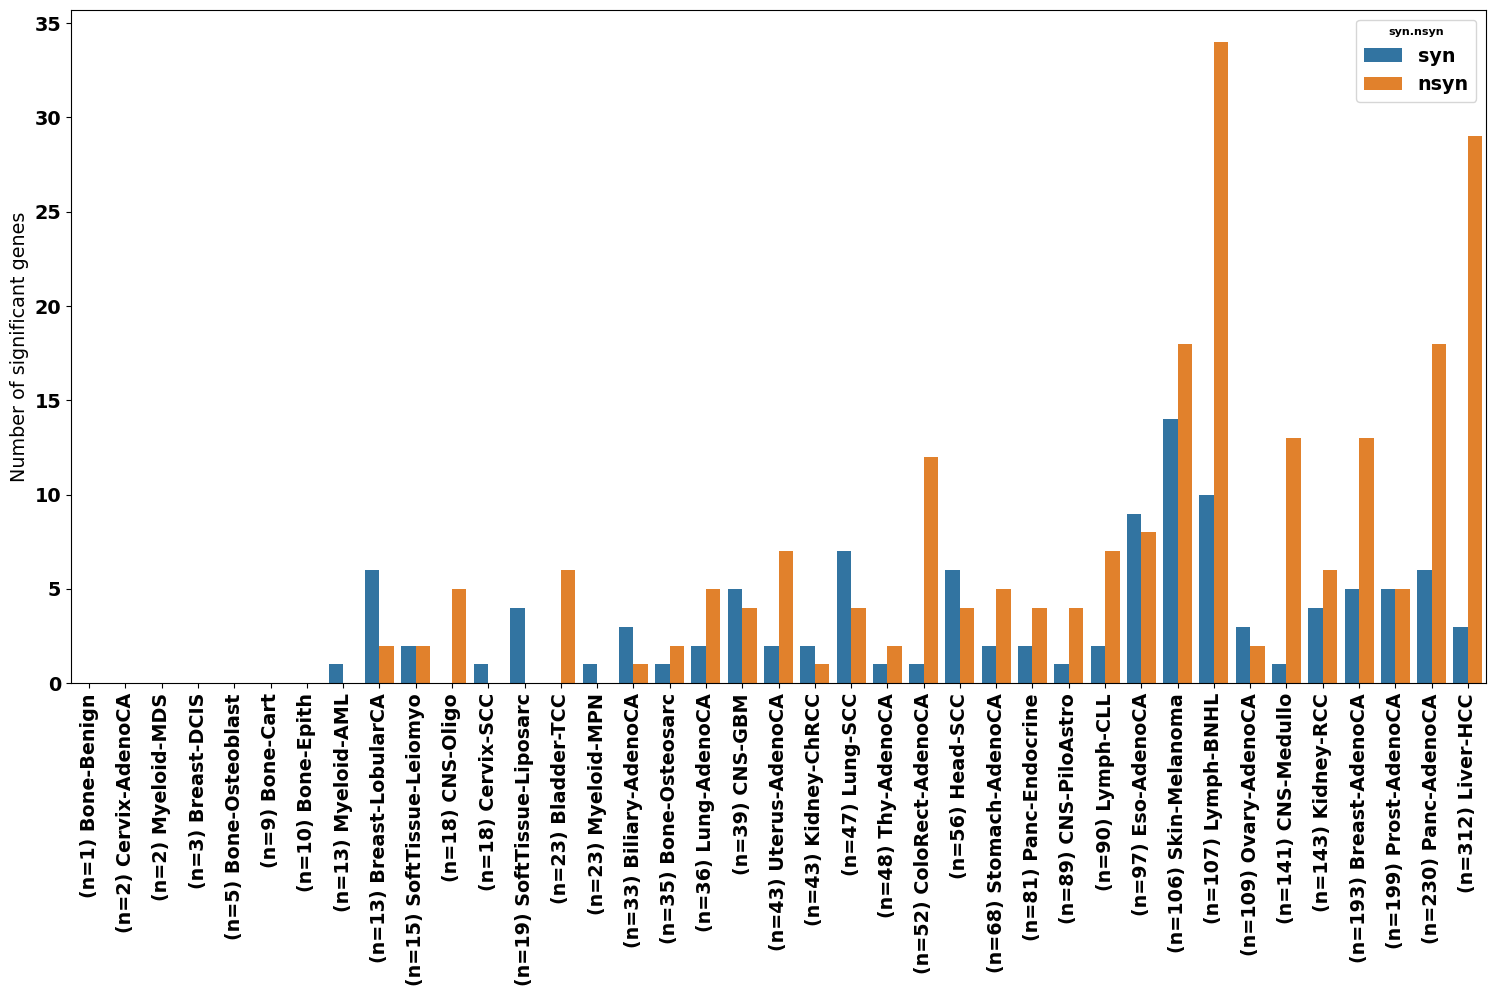

In [240]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
fig,ax = plt.subplots(figsize = (15,10))
ax = sns.barplot(x='index', y='nsig',hue = 'syn.nsyn' ,data=df)
plt.xticks(rotation = 90)
ax.set_ylabel('Number of significant genes'); ax.set_xlabel('')

# for i in range(0, int(len(ax.patches)/2)):
#     p = ax.patches[i+int(len(ax.patches)/2)]
#     feat = lfeat[i]
#     ax.annotate('n='+str(dict_feat_np[feat])\
#                 , (p.get_x() * 0.995, p.get_height() * 1.2), rotation = 90)
plt.tight_layout()

# plt.savefig('./figure4/figs/syn_nsyn.png')